## We repeat what we did in ForceError.ipynb for the Mirror Lab data.
## and see how things changed between Mirror Lab and the summit

In [1]:
from M1M3tools import *
from datetime import datetime
from datetime import timedelta
from datetime import timezone
import os
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle

plt.style.use('classic')

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#These are time stamps we used for the mirror Lab analysis. We keep them for comparison.
# these are in utc already.
myt0 = [1, 25, 17, 54] #33/28nm surfaces
myt1 = [1,14,22,38] #a random time we grabbed from 190118.ipynb
myt2 = [1,18,16,48]

#for summit test, we take a random example: 
# https://jira.lsstcorp.org/secure/Tests.jspa#/testPlayer/LVV-C94   look at LVV-T237(1.0)  step 4.
# there is a attachement.
# The time of entry in Jira was 
# M13T017-20191018_1417UTC.txt	167 kB	Eric Coughlin	18/Oct/19 7:26 am
# This is Jira time, i.e., Tucson time.
# The file name notes that it was 14:17UTC.
# inside the file, we pick a random time where z-forces seemed to be doing something: 
# line#491, time was 2019-10-18T14:20:24

myts = [10, 18, 11, 20] 
#because EFD machine used local time for date_time (insertion time). Local time was 3 hours behind UTC.
# sndStamp and rcvStamp were UTC. We query using date_time.
#This happens to contain  a bump test (lasted a few seconds)

#### Data from test campaign 2 can not be used, because the measured forces are truncated. What about on the summit? Was it truncated too? Great! The answer is no. See below.

#### We load data from Mirror Lab campaign 1.
When csv files exist, the below will just load the csv files, without trying to connect to EFD.

In [3]:
df1 = get_dataframe_EFD(myt0, table_name = 'm1m3_ForceActuatorData')
df2 = get_dataframe_EFD(myt0, table_name = 'm1m3_logevent_AppliedForces')
df3 = get_dataframe_EFD(myt1, table_name = 'm1m3_ForceActuatorData')
df4 = get_dataframe_EFD(myt1, table_name = 'm1m3_logevent_AppliedForces')
df5 = get_dataframe_EFD(myt2, table_name = 'm1m3_ForceActuatorData')
df6 = get_dataframe_EFD(myt2, table_name = 'm1m3_logevent_AppliedForces')

-------Reading from efdData/MeasuredForces_190125_1754.csv-------------
-------Reading from efdData/AppliedForces_190125_1754.csv-------------
-------Reading from efdData/MeasuredForces_190114_2238.csv-------------
-------Reading from efdData/AppliedForces_190114_2238.csv-------------
-------Reading from efdData/MeasuredForces_190118_1648.csv-------------
-------Reading from efdData/AppliedForces_190118_1648.csv-------------


In [4]:
df7 = get_dataframe_EFD(myts, table_name = 'm1m3_ForceActuatorData')
df8 = get_dataframe_EFD(myts, table_name = 'm1m3_logevent_AppliedForces')
df8b = get_dataframe_EFD(myts, 'm1m3_logevent_AppliedBalanceForces')

-------Reading from efdData/MeasuredForces_191018_1120.csv-------------
-------Reading from efdData/AppliedForces_191018_1120.csv-------------
-------Reading from efdData/AppliedBalanceForces_191018_1120.csv-------------


In [5]:
myf1 = assembleFinst(df1, 1, 1)
myf2 = assembleFinst(df2, 1, 1)
myf3 = assembleFinst(df3, 1, 1)
myf4 = assembleFinst(df4, 1, 1)
myf5 = assembleFinst(df5, 1, 1)
myf6 = assembleFinst(df6, 1, 1)

In [6]:
myf7 = assembleFinst(df7, 3, 1)
myf8 = assembleFinst(df8, 3, 1)

#### Unfortunately the two force tables STILL have different number of messages.

In [7]:
print(myf7.shape, myf8.shape)

(924, 156, 4) (895, 156, 4)


#### The timestamps for sending the messages were different! So we cannot do a simple element-wise subtraction

#### We set the earliest time stamp to be t=0, and latest time stamp to be tmax. After that we bin the data using the time stamps. 
In example below we choose time interval for averaging to be 1 second.
fdiff is the force difference after binning the data.

In [8]:
def get_fdiff_from_myf12(df1, df2, campn = 1, dt=1):
    myf1 = assembleFinst(df1, campn, 1)
    myf2 = assembleFinst(df2, campn, 1)
    
    t0 = min(min(df1.private_sndStamp), min(df2.private_sndStamp))
    tmax = max(max(df1.private_sndStamp), max(df2.private_sndStamp))-t0
    t1 = np.array(df1.private_sndStamp - t0)
    t2 = np.array(df2.private_sndStamp - t0)
    nt = int(np.ceil(tmax/dt))
    fdiff = np.zeros((nt, nActuator, 4))
    for it in range(nt):
        idx1 = np.logical_and(t1>dt*it, t1<dt*(it+1)) #time binning
        idx2 = np.logical_and(t2>dt*it, t2<dt*(it+1)) #time binning
        if np.any(idx1) == True and np.any(idx2) == True:
            fdiff[it,:,:] = np.mean(myf1[idx1,:,:], axis=0) - np.mean(myf2[idx2,:,:], axis=0)
        else:
            fdiff[it,:,:] = np.nan
    fdiff[:,:,0] = actID  #checked fdiff[:2,:,0]. This is OK.
    idxx = ~(np.logical_and(myf1[0,:,1]==0, myf2[0,:,1]==0))#which actuators have x force
    idxy = ~(np.logical_and(myf1[0,:,2]==0, myf2[0,:,2]==0))#which actuators have y force
    fdiff[:,~idxx,1] = np.nan
    fdiff[:,~idxy,2] = np.nan
    return fdiff

In [9]:
fdiff1 = get_fdiff_from_myf12(df1, df2, campn=1)
fdiff2 = get_fdiff_from_myf12(df3, df4, campn=1)
fdiff3 = get_fdiff_from_myf12(df5, df6, campn=1)

In [10]:
fdiff4 = get_fdiff_from_myf12(df7, df8, campn=3)

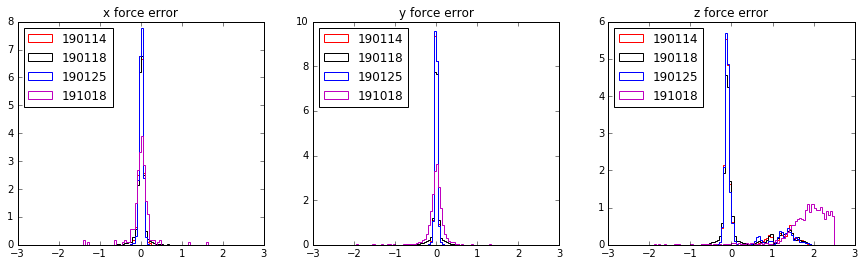

In [11]:
xbin = np.linspace(-2.5,2.5,101)
idxx = ~(np.logical_and(myf1[0,:,1]==0, myf2[0,:,1]==0))#which actuators have x force
idxy = ~(np.logical_and(myf1[0,:,2]==0, myf2[0,:,2]==0))#which actuators have y force

fig, ax = plt.subplots(1, 3, figsize = (15,4))

idx = ~np.isnan(fdiff2[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff2[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')
ax[1].hist(fdiff2[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')
ax[2].hist(fdiff2[idx,:,3].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')

idx = ~np.isnan(fdiff3[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff3[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')
ax[1].hist(fdiff3[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')
ax[2].hist(fdiff3[idx,:,3].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')

idx = ~np.isnan(fdiff1[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff1[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')
ax[1].hist(fdiff1[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')
ax[2].hist(fdiff1[idx,:,3].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')

idx = ~np.isnan(fdiff4[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff4[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='m',histtype='step', density=True, label='191018')
ax[1].hist(fdiff4[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='m',histtype='step', density=True, label='191018')
ax[2].hist(fdiff4[idx,:,3].reshape(-1,1), bins=xbin, color='m',histtype='step', density=True, label='191018')

ax[0].set_title('x force error')
ax[1].set_title('y force error')
ax[2].set_title('z force error')
for i in range(3):
    ax[i].legend(loc='upper left')

#### We did not use much x or y forces at zenith pointing. They look OK. z-forces have some large differences.
Below we first verify that these large differences are real - indeed in the data.

In [12]:
np.max(fdiff4[idx,:,3])

6.545427862608694

In [14]:
idxt = np.where(fdiff4[:,:,3]>6)

In [15]:
idxt

(array([17]), array([136]))

### So what happended in those 4 minutes?
#### play with ts and te a bit, one can see that there is a bump test at ~12s - 18s

In [18]:
t0 = min(min(df7.private_sndStamp), min(df8.private_sndStamp))
tmax = max(max(df7.private_sndStamp), max(df8.private_sndStamp))-t0
t1 = np.array(df7.private_sndStamp - t0)
t2 = np.array(df8.private_sndStamp - t0)

In [19]:
tmax

18.47143793106079

### There is no more data after 18.5 seconds

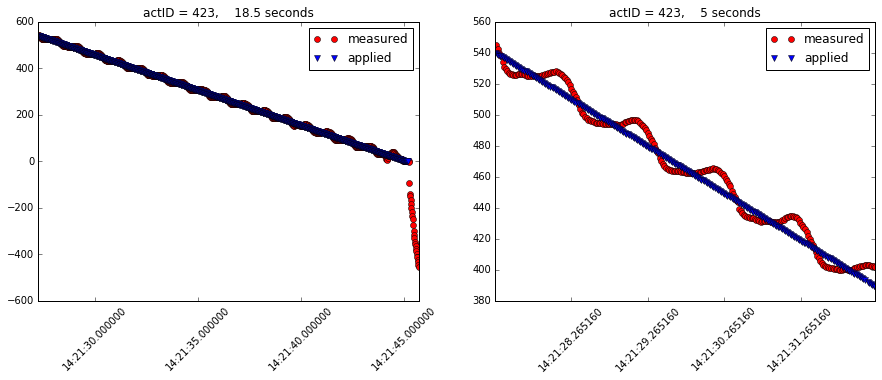

In [26]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
plt.subplots_adjust(hspace=0.5)
iact = idxt[1][0] #look at the same actuator as before

ts = 0
te = ts+240
idx1 = np.logical_and(t1>ts, t1<te)
idx2 = np.logical_and(t2>ts, t2<te)
ax[0].plot(pd.to_datetime(df7.private_sndStamp[idx1], unit='s'),myf7[idx1,iact,3],'ro',label='measured')
ax[0].plot(pd.to_datetime(df8.private_sndStamp[idx2], unit='s'),myf8[idx2,iact,3],'vb',label='applied')
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=45 );
ax[0].set_title('actID = %d,    18.5 seconds'%(actID[iact]))
ax[0].legend()

ts = 0
te = ts+5
idx1 = np.logical_and(t1>ts, t1<te)
idx2 = np.logical_and(t2>ts, t2<te)
ax[1].plot(pd.to_datetime(df7.private_sndStamp[idx1], unit='s'),myf7[idx1,iact,3],'ro',label='measured')
ax[1].plot(pd.to_datetime(df8.private_sndStamp[idx2], unit='s'),myf8[idx2,iact,3],'vb',label='applied')
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=45 );
ax[1].set_title('actID = %d,    5 seconds'%(actID[iact]))
ax[1].legend()

### Doug: Possible disturbances include:
Normal testing
Fluctuations in air pressure.
Someone working on the mirror
Seismic events.
Etc

### But at least the applied forces should be the total (according to Mirror Lab testing), 
### so any FB force should be included there already?
### Unfortunately the below is empty.

In [27]:
df8b

,Unnamed: 0,date_time,private_revCode,private_sndStamp,private_rcvStamp,private_seqNum,private_origin,private_host,Timestamp,XForces_1,...,YForces,ZForces,Fx,Fy,Fz,Mx,My,Mz,ForceMagnitude,priority
0,0,2019-10-18 11:18:17.943351,LSST TES,1.571409e+09,1.571408e+09,43182679,1,1,1.571409e+09,0.0,...,0.000000 0.000000 0.000000 0.000000 0.000000 0...,0.000000 0.000000 0.000000 0.000000 0.000000 0...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### What other information could we look at to know more about what happended?

In [28]:
filename = 'efdData/table_list3.txt'
if not os.path.isfile(filename):
    fid = open(filename, 'w')
    tables = pd.read_sql_query('show tables', engine1)
    for table in tables['Tables_in_EFD']:
        if table.startswith('m1m3'):
            print(table)
            fid.write('%s\n'%table)
    fid.close()
else:
    print('-------Reading from %s-------------'%filename)
    fid = open(filename, 'r')
    for line in fid:
        print(line.strip())
    fid.close()
#df7p = get_dataframe_EFD(myts, table_name = 'M1M3_forceActuatorPressure')

-------Reading from efdData/table_list3.txt-------------
m1m3_AccelerometerData
m1m3_ForceActuatorData
m1m3_GyroData
m1m3_HardpointActuatorData
m1m3_HardpointMonitorData
m1m3_IMSData
m1m3_InclinometerData
m1m3_OuterLoopData
m1m3_PIDData
m1m3_PowerSupplyData
m1m3_commandLog
m1m3_command_AbortProfile
m1m3_command_AbortRaiseM1M3
m1m3_command_ApplyAberrationForces
m1m3_command_ApplyAberrationForcesByBendingModes
m1m3_command_ApplyActiveOpticForces
m1m3_command_ApplyActiveOpticForcesByBendingModes
m1m3_command_ApplyOffsetForces
m1m3_command_ApplyOffsetForcesByMirrorForce
m1m3_command_ClearAberrationForces
m1m3_command_ClearActiveOpticForces
m1m3_command_ClearOffsetForces
m1m3_command_Disable
m1m3_command_DisableHardpointChase
m1m3_command_DisableHardpointCorrections
m1m3_command_Enable
m1m3_command_EnableHardpointChase
m1m3_command_EnableHardpointCorrections
m1m3_command_EnterEngineering
m1m3_command_ExitEngineering
m1m3_command_LowerM1M3
m1m3_command_ModbusTransmit
m1m3_command_MoveHardpoi

In [29]:
df7as = get_dataframe_EFD(myts, 'm1m3_logevent_AirSupplyStatus')
df7aw = get_dataframe_EFD(myts, 'm1m3_logevent_AirSupplyWarning')

-------Reading from efdData/AirSupplyStatus_191018_1120.csv-------------
-------Reading from efdData/AirSupplyWarning_191018_1120.csv-------------


In [30]:
df7aw

,Unnamed: 0,date_time,private_revCode,private_sndStamp,private_rcvStamp,private_seqNum,private_origin,private_host,Timestamp,AnyWarning,CommandOutputMismatch,CommandSensorMismatch,priority


In [31]:
df7as

,Unnamed: 0,date_time,private_revCode,private_sndStamp,private_rcvStamp,private_seqNum,private_origin,private_host,Timestamp,AirCommandedOn,AirCommandOutputOn,AirValveOpened,AirValveClosed,priority
